# OTI Comparison with iterative multidual implementation.



This comparison is intended to compare, with no implementation-specific boost, multidual algebra with OTI algebra.


For this case, multidual and OTI implementation are compared using its matrix forms in sparse format (Compressed Sparse Row matrix)


The followign function is used to implement the procedure.


$$
f(x_1,x_2,...,x_m) = \prod_{i=1}^{m}\sin(x_i)
$$


The goal is to compute the total time it takes to compute all derivatives of $m$ variables up to order $n$





In [1]:
# 1. SET GLOBAL PATH 
import sys
path2oti = '../'
sys.path.append(path2oti) # Add path to OTI library.
path2mdl = '../../aaguirr2/multi-z/Python/'
sys.path.append(path2mdl) # Add path to MDL library.

# 2. OTI LIBRARY
import otilib as oti
np = oti.np
oti_e = oti.e


# 3. MULTIDUAL LIBRARY
import multiZ.mdual as mdl


# 4. SPARSE MATRIX LIBRARY.
import scipy as sp



# 5. TIME MEASURING 
import time

# 6. PLOTTING
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import MultipleLocator, FormatStrFormatter


In [2]:
colors = ['m','b','g','c','r','k']
o_patch = []

In [3]:

nvarsTotal = 60
x_realVals = np.arange(0.01,2*np.pi,2*np.pi/nvarsTotal)

# sp.sparse.csr_matrix

h = oti.get_dHelp()

In [4]:
def numExp(num):
    if num == 1:
        return 'st'
    elif num == 2:
        return 'nd'
    elif num==3:
        return 'rd'
    else:
        return 'th'
    # end 

In [5]:
def f(X_oti):
    # Create empty holder
    res = sp.sparse.csr_matrix(np.eye(X_oti[0].shape[0]))
    for i in range(len(X_oti)):
        res = res*X_oti[i].sin()
    # end for 
    return res
# end 

In [6]:
def ffast(X_oti):
    # Create empty holder
    res = np.zeros(X_oti[0].shape[0])
    res[0]=1
    for i in range(len(X_oti)):
        res = X_oti[i].sin()*res
    # end for 
    return res
# end 

In [7]:
def multidual_numevals_efficient(m,order):
    
    return sp.special.comb(order+m-1,m-1,exact=True)

In [8]:
def mdualGetMatPos(dirBasis,maxBasis):
    
    maxBin= 2**maxBasis-1
    binEq = 2**(dirBasis-1)
    bitLenght = dirBasis
    
    bit64= (2**64-1)^maxBin
    dimR = dirBasis-1
    dimL = maxBasis-dirBasis
    col = np.empty(2**(maxBasis-1),dtype = np.uint64)
    row = np.empty(2**(maxBasis-1),dtype = np.uint64)
    
    
    for i in range( 0, ( 2**(maxBasis-1) ) ):
                  
        left = i >> dimR << dimR
        right  = (i^left) 
        left = left<<1
        
        
        row[i] = left+right+binEq
        col[i] = left+right
        
    return row,col

In [9]:
%timeit mdualGetMatPos(5,10)

270 µs ± 4.14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%timeit oti.get_CR_mdl(5,10)

6.13 µs ± 139 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [11]:
variables = [1,5,10,15,20,25,30,35,40,45,50,55,60]
# orders = [1,2,3,4,5]
orders = [1,2,3]
cputimes = np.empty((len(variables)*len(orders),3),dtype=np.float64)
k = 0
for orderAnalysis in orders:
    print(orderAnalysis)
    for nvarAnalysis in variables:
        print("-"+str(nvarAnalysis))
       
        
        # create oti matrices:
#         nvarAnalysis = 10
#         orderAnalysis = 5
#         baseMatr = oti.get_CR(nvarAnalysis,orderAnalysis)
        X_oti = []
        factor = 0.0
        
        for i in range(len(x_realVals)):

            if i<nvarAnalysis:
                factor = 1.0
            else:
                factor = 0.0
            # end if 
            
            x_oti_tmp = x_realVals[i]+factor*oti_e(i+1,order = orderAnalysis, m =nvarAnalysis)
            X_oti.append( sp.sparse.csr_matrix(x_oti_tmp.toMatrix(m=nvarAnalysis)) )
        #     X_oti.append( sp.sparse.csr_matrix(x_oti_tmp.toMatrix(m=nvarAnalysis,isspr=True) ))

        # end for 
        
        nevals = 1
        start = time.time()
        
        for i in range(nevals):
            f_eval_oti = f(X_oti)
        # end for 
        
        end = time.time()
        
        cputimes[k,0] = nvarAnalysis
        cputimes[k,1] = orderAnalysis
        cputimes[k,2] = (end-start)/nevals*1000 # time in us
        
        k+=1
        
        
        
        
    # end for 

# end for




1
-1
-5
-10
-15
-20
-25
-30
-35
-40
-45
-50
-55
-60
2
-1
-5
-10
-15
-20
-25
-30
-35
-40
-45
-50
-55
-60
3
-1
-5
-10
-15
-20
-25
-30
-35
-40
-45
-50
-55
-60


In [13]:
variables = [1,5,10,15,20,25,30,35,40,45,50,55,60]
# orders = [1,2,3,4,5]
orders = [1,2,3]
cputimes = np.empty((len(variables)*len(orders),3),dtype=np.float64)
k = 0
for orderAnalysis in orders:
    print(orderAnalysis)
    for nvarAnalysis in variables:
        print("-"+str(nvarAnalysis))
        
        baseMatr = oti.get_CR(nvarAnalysis,orderAnalysis).tocoo()
        eyeMatr = sp.sparse.diags([1],0,shape=baseMatr.shape,format="lil")
        X_oti = []
        factor = 0.0
        
        for i in range(len(x_realVals)):
            
            x_oti_tmp = x_realVals[i]*eyeMatr
            
            if i<nvarAnalysis:
                pos = h.getNels(i,orderAnalysis)
                indxPos, = np.where(baseMatr.data==pos+1)
#                 print(indxPos)
                for kkk in indxPos:
                    x_oti_tmp[baseMatr.row[kkk],baseMatr.col[kkk] ] = 1.0
                # end for 
#             else:
                
            # end if 

#             x_oti_tmp = x_realVals[i]+factor*oti_e(i+1,order = orderAnalysis, m =nvarAnalysis)
#             X_oti.append( sp.sparse.csr_matrix(x_oti_tmp.toMatrix(m=nvarAnalysis)) )
            X_oti.append(x_oti_tmp.tocsr())
        #     X_oti.append( sp.sparse.csr_matrix(x_oti_tmp.toMatrix(m=nvarAnalysis,isspr=True) ))

        # end for 
        
        nevals = 1
        start = time.time()
        
        for i in range(nevals):
            f_eval_oti = f(X_oti)
        # end for 
        
        end = time.time()
        
        cputimes[k,0] = nvarAnalysis
        cputimes[k,1] = orderAnalysis
        cputimes[k,2] = (end-start)/nevals*1000 # time in us
        
        k+=1
        
        
        
        
    # end for 

# end for





1
-1
-5
-10
-15
-20
-25
-30
-35
-40
-45
-50
-55
-60
2
-1
-5
-10
-15
-20
-25
-30
-35
-40
-45
-50
-55
-60
3
-1
-5
-10
-15
-20
-25
-30
-35
-40
-45
-50
-55
-60


In [14]:
variables = [1,5,10,15,20,25,30,35,40,45,50,55,60]
# orders = [1,2,3,4,5]
orders = [1,2,3]
cputimes2 = np.empty((len(variables)*len(orders),3),dtype=np.float64)
k = 0
for orderAnalysis in orders:
    print(orderAnalysis)
    for nvarAnalysis in variables:
        print("-"+str(nvarAnalysis))
       
        
        # create oti matrices:
#         nvarAnalysis = 10
#         orderAnalysis = 5
        baseMatr = oti.get_CR(nvarAnalysis,orderAnalysis).tocoo()
        eyeMatr = sp.sparse.diags([1],0,shape=baseMatr.shape,format="lil")
        X_oti = []
        factor = 0.0
        for i in range(len(x_realVals)):
            
                        
            x_oti_tmp = x_realVals[i]*eyeMatr
            
            if i<nvarAnalysis:
                pos = h.getNels(i,orderAnalysis)
                indxPos, = np.where(baseMatr.data==pos+1)
                for kkk in indxPos:
                    x_oti_tmp[baseMatr.row[kkk],baseMatr.col[kkk] ] = 1.0
                # end for 
                
            # end if 
            X_oti.append(x_oti_tmp.tocsr())



#             if i<nvarAnalysis:
#                 factor = 1.0
#             else:
#                 factor = 0.0
#             # end if 

#             x_oti_tmp = x_realVals[i]+factor*oti_e(i+1,order = orderAnalysis, m =nvarAnalysis)
#             X_oti.append( sp.sparse.csr_matrix(x_oti_tmp.toMatrix(m=nvarAnalysis)) )
#         #     X_oti.append( sp.sparse.csr_matrix(x_oti_tmp.toMatrix(m=nvarAnalysis,isspr=True) ))

        # end for 
        
        nevals = 10
        start = time.time()
        
        for i in range(nevals):
            f_eval_oti = ffast(X_oti)
        # end for 
        
        end = time.time()
        
        cputimes2[k,0] = nvarAnalysis
        cputimes2[k,1] = orderAnalysis
        cputimes2[k,2] = (end-start)/nevals*1000 # time in us
        
        k+=1
        
        
        
        
    # end for 

# end for





1
-1
-5
-10
-15
-20
-25
-30
-35
-40
-45
-50
-55
-60
2
-1
-5
-10
-15
-20
-25
-30
-35
-40
-45
-50
-55
-60
3
-1
-5
-10
-15
-20
-25
-30
-35
-40
-45
-50
-55
-60


# Multi-Dual implementation


In [ ]:
variables_mdl = [[1,3,5,7,9,11,13,15,17,19,21,23,25,27],[1,3,5,7,9,11,13],[1,3,5,7,9]]
orders_mdl = [1,2,3]

cputimes_mdl = [np.empty((len(variables_mdl[0]),3),dtype=np.float64),
               np.empty((len(variables_mdl[1]),3),dtype=np.float64),
               np.empty((len(variables_mdl[2]),3),dtype=np.float64),]
# k = 0
for orderAnalysis in orders_mdl:
    k = 0
    print(orderAnalysis)
    for nvarAnalysis in variables_mdl[orderAnalysis-1]:
       
        
        X_mdl = []
        factor = 0.0
#         base_mdl = mdl.mdual(np.zeros(2**(orderAnalysis*nvarAnalysis)))
        size = 2**(orderAnalysis*nvarAnalysis)
        eyeMatr = sp.sparse.diags([1],0,shape=(size,size),format="lil")
        
        kk=1
        

        print('-',nvarAnalysis)

        for i in range(len(x_realVals)):
            

            
            x_mdl_tmp = eyeMatr*x_realVals[i]
            
            if i<nvarAnalysis:
                
                # The first idea is to evaluate "brute force method, all derivatives in one analysis
                
                for o in range(orderAnalysis):
                    rows,cols =oti.get_CR_mdl(kk,orderAnalysis*nvarAnalysis)
                    x_mdl_tmp[rows,cols] = 1.0
                    kk+=1
                
                # end for
                
            # end if 
            
            X_mdl.append( x_mdl_tmp.tocsr()  )
            
            
            
            
            
#             x_mdl_tmp = base_mdl + x_realVals[i]
            
#             if i<nvarAnalysis:
                
#                 # The first idea is to evaluate "brute force method, all derivatives in one analysis
                
#                 for o in range(orderAnalysis):
                
#                     x_mdl_tmp += mdl.eps(kk)
#                     kk+=1
                
#                 # end for
                
#             # end if 
            
#             X_mdl.append( sp.sparse.csr_matrix( x_mdl_tmp.tomatrix() ) )

        # end for 
        
        nevals = 10
        start = time.time()
        
        for i in range(nevals):
            f_eval_oti = ffast(X_mdl)
        # end for 
        
        end = time.time()
        
        cputimes_mdl[orderAnalysis-1][k,0] = nvarAnalysis
        cputimes_mdl[orderAnalysis-1][k,1] = orderAnalysis
        cputimes_mdl[orderAnalysis-1][k,2] = (end-start)/nevals*1000 # time in us
        
        k+=1
        print('finished computing !\n')
        
        
        
    # end for 

# end for





1
- 1
finished computing !

- 3
finished computing !

- 5
finished computing !

- 7
finished computing !

- 9
finished computing !

- 11
finished computing !

- 13
finished computing !

- 15
finished computing !

- 17
finished computing !

- 19
finished computing !

- 21
finished computing !

- 23


In [17]:
# variables = [1,2,3,4,5,6,7,8]
# orders = [1,2]


cputimes_mmdl = np.empty((len(variables)*len(orders),3),dtype=np.float64)
k = 0
for orderAnalysis in orders:
    for nvarAnalysis in variables:
       
        
        # create oti matrices:
        X_mdl = []
        factor = 0.0
        base_mdl = mdl.mdual(np.zeros(2**(orderAnalysis)))
        
        
        for i in range(len(x_realVals)):
            
            x_mdl_tmp = base_mdl + x_realVals[i]
            if i<nvarAnalysis:
                # The first idea is to evaluate "brute force method, all derivatives in one analysis
                kk=1
                for o in range(orderAnalysis):
                    x_mdl_tmp += mdl.eps(kk)
                    kk+=1
 
                    # print(x_mdl_tmp)
                # end for
                
            # end if 
            
            X_mdl.append( sp.sparse.csr_matrix( x_mdl_tmp.tomatrix() ) )
        #     X_oti.append( sp.sparse.csr_matrix(x_oti_tmp.toMatrix(m=nvarAnalysis,isspr=True) ))

        # end for 
        
        nevals = 10
        start = time.time()
        
        for i in range(nevals):
            f_eval_oti = f(X_mdl)
        # end for 
        
        end = time.time()
        
        cputimes_mmdl[k,0] = nvarAnalysis
        cputimes_mmdl[k,1] = orderAnalysis
        cputimes_mmdl[k,2] = (end-start)/nevals*1000*multidual_numevals_efficient(nvarAnalysis,orderAnalysis) # time in us
        
        k+=1
#         print('finished computing !\n')
        
        
        
    # end for 

# end for

In [ ]:
# variables = [1,2,3,4,5,6,7,8]
# orders = [1,2]


cputimes_mmdl2 = np.empty((len(variables)*len(orders),3),dtype=np.float64)
k = 0
for orderAnalysis in orders:
    print(orderAnalysis)
    for nvarAnalysis in variables:
        print('-'+str(nvarAnalysis))
        
        # create oti matrices:
#         nvarAnalysis = 10
#         orderAnalysis = 5

        X_mdl = []
        factor = 0.0
        base_mdl = mdl.mdual(np.zeros(2**(orderAnalysis)))
        
        
#         print('order analysis: ',orderAnalysis)
#         print('number of variabels: ',nvarAnalysis)
        for i in range(len(x_realVals)):
            
            x_mdl_tmp = base_mdl + x_realVals[i]
            if i<nvarAnalysis:
                # The first idea is to evaluate "brute force method, all derivatives in one analysis
#                 print(kk)
                kk=1
                for o in range(orderAnalysis):
                    x_mdl_tmp += mdl.eps(kk)
                    kk+=1
 
                    # print(x_mdl_tmp)
                # end for
                
            # end if 
            
            X_mdl.append( sp.sparse.csr_matrix( x_mdl_tmp.tomatrix() ) )
        #     X_oti.append( sp.sparse.csr_matrix(x_oti_tmp.toMatrix(m=nvarAnalysis,isspr=True) ))

        # end for 
        
        nevals = 10
        start = time.time()
        
        for i in range(nevals):
            f_eval_oti = ffast(X_mdl)
        # end for 
        
        end = time.time()
        
        cputimes_mmdl2[k,0] = nvarAnalysis
        cputimes_mmdl2[k,1] = orderAnalysis
        cputimes_mmdl2[k,2] = (end-start)/nevals*1000*multidual_numevals_efficient(nvarAnalysis,orderAnalysis) # time in us
        
        k+=1
#         print('finished computing !\n')
        
        
        
    # end for 

# end for

<IPython.core.display.Javascript object>


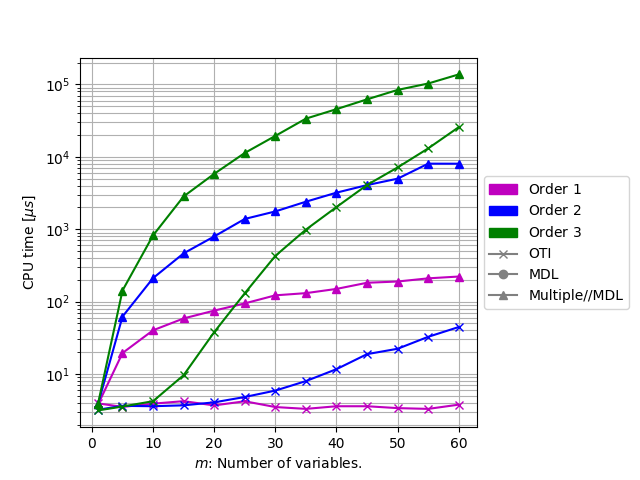

In [28]:
o_patch = []
# ax = plt.subplot(111)
# ax=plt.figure()
plt.figure()
ax = plt.subplot(111)
for i in range(len(orders)):
    
    plt.semilogy(variables,cputimes[i*len(variables):(i+1)*len(variables),2],colors[i]+'-x') 
#     plt.loglog(variables,cputimes_mdl[i*len(variables):(i+1)*len(variables),2],colors[i]+'-o') 
    plt.semilogy(variables,cputimes_mmdl[i*len(variables):(i+1)*len(variables),2],colors[i]+'-^') 
    o_patch.append(mpatches.Patch(color=colors[i%len(colors)], label='Order $'+str(orders[i])+'$'))
    
# for i in range(len(orders_mdl)):
    
#     plt.loglog(variables_mdl,cputimes_mdl[i*len(variables_mdl):(i+1)*len(variables_mdl),2],colors[i]+'-o') 
    

    
    
# End function   


o_patch.append( mlines.Line2D([], [], color='gray',marker='x',label='OTI') )  
o_patch.append( mlines.Line2D([], [], color='gray',marker='o',label='MDL') )  
o_patch.append( mlines.Line2D([], [], color='gray',marker='^',label='Multiple//MDL') )  

plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')
# plt.ylim([1,15])
plt.ylabel('CPU time [$\mu s$]')
plt.xlabel('$m$: Number of variables.')
plt.legend(handles=o_patch,loc='center left', bbox_to_anchor=(1, 0.5))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])


# plt.xlim([1,100])
plt.savefig("OTIvsMMDL_CompTimes1.pdf",dpi=300)
plt.show()

In [ ]:
o_patch = []
# ax = plt.subplot(111)
# ax=plt.figure()
plt.figure()
ax = plt.subplot(111)

alphaMDL  = 1.0
alphaRMDL = 1.0
alphaOTI  = 1.0

for i in range(len(orders)):
    
    plt.semilogy(variables,cputimes2[i*len(variables):(i+1)*len(variables),2],colors[i]+'-',alpha=alphaOTI) 
    plt.semilogy(variables,cputimes_mmdl2[i*len(variables):(i+1)*len(variables),2],colors[i]+'-^', alpha=alphaRMDL) 
    o_patch.append(mpatches.Patch(color=colors[i%len(colors)], label='$'+str(orders[i])+'^{'+numExp(orders[i])+'}$ order'))

    
for i in range(len(orders_mdl)):
    
    plt.semilogy(variables_mdl[i],cputimes_mdl[i][:,2],colors[i]+'--', alpha=alphaMDL)    
    
# End for
if alphaMDL >0.0:
    o_patch.append( mlines.Line2D([], [], color='gray',ls='--',label='MDL',alpha=alphaMDL) ) 
    stage = '1'
if alphaRMDL > 0.0:
    o_patch.append( mlines.Line2D([], [], color='gray',marker='^',label='Repetitive\nMDL',alpha=alphaRMDL) )  
    stage = '2'
if alphaOTI > 0.0:
    o_patch.append( mlines.Line2D([], [], color='gray',label='OTI',alpha=alphaOTI) )  
    stage = '3'
# end if
 


plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')
# plt.ylim([1,15])
plt.ylabel('CPU time [$\mu s$]')
plt.xlabel('$m$: Number of variables.')
plt.legend(handles=o_patch,loc='center left', bbox_to_anchor=(1, 0.5))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])


# plt.xlim([1,100])
plt.savefig("OTIvsMMDL_CompTimes_semilog_"+stage+".pdf",dpi=300)
plt.show()

<IPython.core.display.Javascript object>


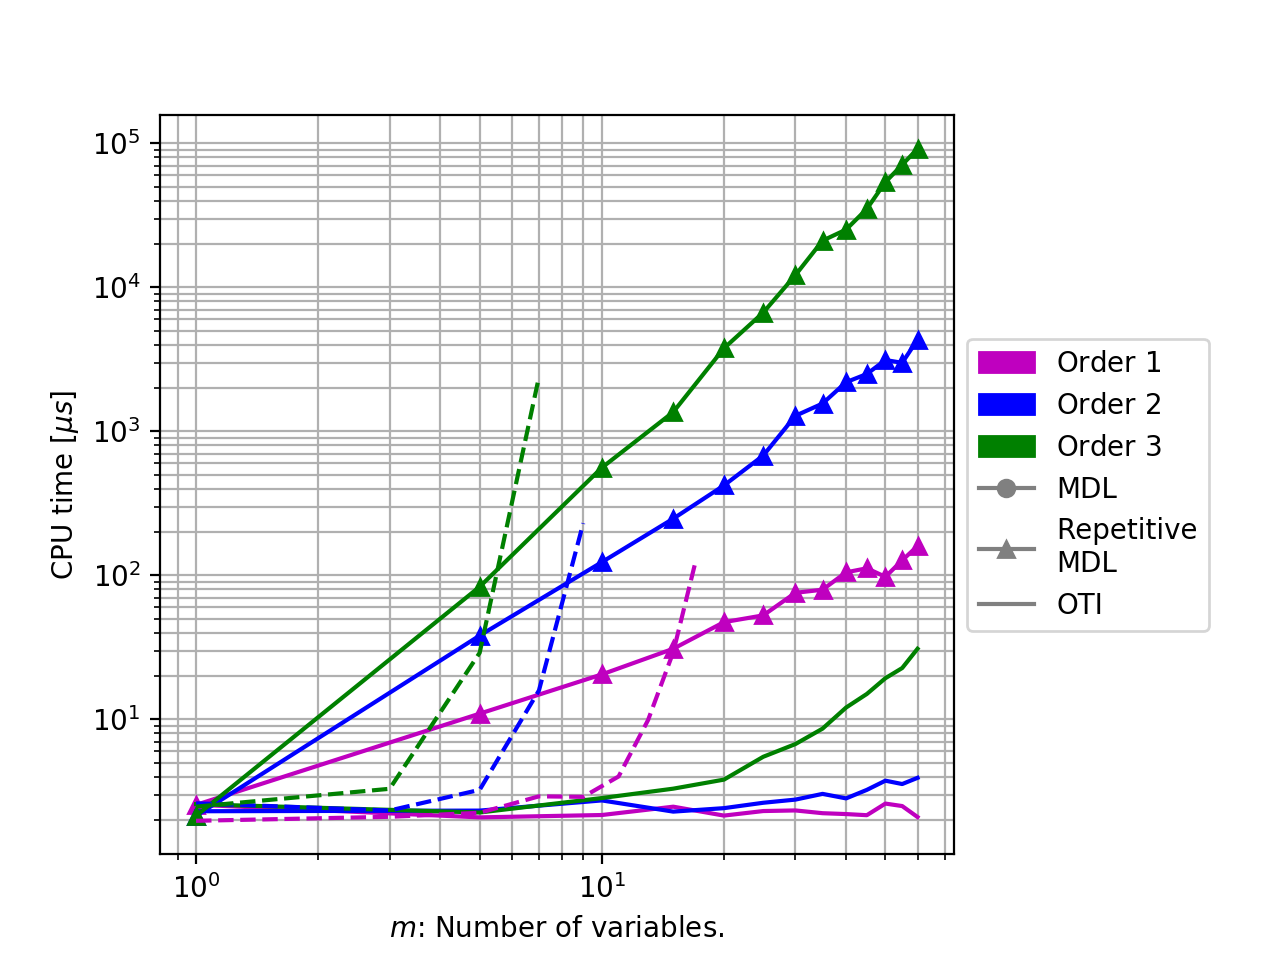

In [42]:
o_patch = []
# ax = plt.subplot(111)
# ax=plt.figure()
plt.figure()
ax = plt.subplot(111)
for i in range(len(orders)):
    
    plt.loglog(variables,cputimes2[i*len(variables):(i+1)*len(variables),2],colors[i]+'-') 
    plt.loglog(variables,cputimes_mmdl2[i*len(variables):(i+1)*len(variables),2],colors[i]+'-^') 
    o_patch.append(mpatches.Patch(color=colors[i%len(colors)], label='Order $'+str(orders[i])+'$'))
    
# End for   


for i in range(len(orders_mdl)):
    
    plt.loglog(variables_mdl[i],cputimes_mdl[i][:,2],colors[i]+'--', alpha=alphaMDL)    
    
# End for


o_patch.append( mlines.Line2D([], [], color='gray',marker='o',label='MDL') )  
o_patch.append( mlines.Line2D([], [], color='gray',marker='^',label='Repetitive\nMDL') )  
o_patch.append( mlines.Line2D([], [], color='gray',ls='-',label='OTI') )  
plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')
# plt.ylim([1,15])
plt.ylabel('CPU time [$\mu s$]')
plt.xlabel('$m$: Number of variables.')
plt.legend(handles=o_patch,loc='center left', bbox_to_anchor=(1, 0.5))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])


# plt.xlim([1,100])

plt.savefig("OTIvsMMDL_CompTimes_loglog1.pdf",dpi=300)
plt.show()

In [45]:
i=-14
cputimes_mmdl[i,2]/cputimes[i,2]

196.43648513771183

<IPython.core.display.Javascript object>


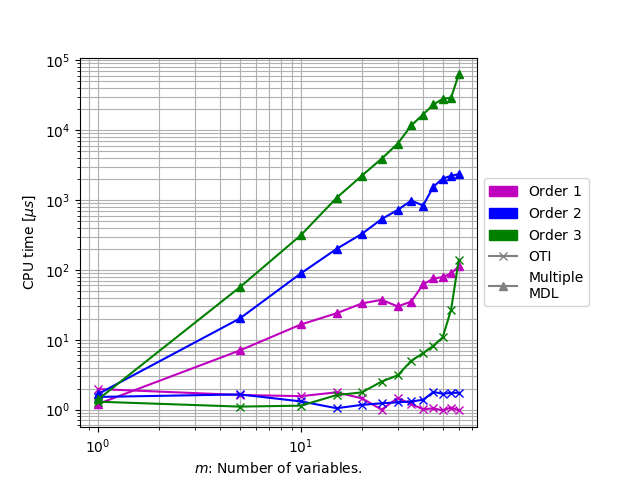

In [27]:
o_patch = []
# ax = plt.subplot(111)
# ax=plt.figure()
plt.figure()
ax = plt.subplot(111)
for i in range(len(orders)):
    
    plt.loglog(variables,cputimes2[i*len(variables):(i+1)*len(variables),2],colors[i]+'-x') 
#     plt.loglog(variables,cputimes_mdl[i*len(variables):(i+1)*len(variables),2],colors[i]+'-o') 
    plt.loglog(variables,cputimes_mmdl2[i*len(variables):(i+1)*len(variables),2],colors[i]+'-^') 
    o_patch.append(mpatches.Patch(color=colors[i%len(colors)], label='Order $'+str(orders[i])+'$'))
    

    
    
# End function   


o_patch.append( mlines.Line2D([], [], color='gray',marker='x',label='OTI') )  
# o_patch.append( mlines.Line2D([], [], color='gray',marker='o',label='MDL') )  
o_patch.append( mlines.Line2D([], [], color='gray',marker='^',label='Multiple\nMDL') )  

plt.grid(b=True, which='major')
plt.grid(b=True, which='minor')
# plt.ylim([1,15])
plt.ylabel('CPU time [$\mu s$]')
plt.xlabel('$m$: Number of variables.')
plt.legend(handles=o_patch,loc='center left', bbox_to_anchor=(1, 0.5))

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])


# plt.xlim([1,100])

plt.savefig("OTIvsMMDL_CompTimes_loglog2.pdf",dpi=300)
plt.show()